In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
tp53data_dir = '../../data/tp53_data'
tert_data_dir = '../../data/tert_data'
output_dir = './plots'

# TP53 mutations

In [4]:
table_file = os.path.join(tp53data_dir,'TP53_merged_data.tsv')

In [5]:
table = pd.read_csv(table_file,sep='\t')

In [6]:
table['consequence_normal'].value_counts()

consequence_normal
missense                 328
synonymous                41
nonsense                  29
essential_splice          22
splice_region_variant     17
intron_variant             4
Name: count, dtype: int64

In [7]:
def group_normal_consequence(r):
    if r['consequence_normal'] == 'missense':
        return 'missense'
    elif r['consequence_normal'] == 'nonsense' or r['consequence_normal'] == 'essential_splice':
        return 'truncating'
    elif r['consequence_normal'] == 'synonymous':
        return 'synonymous'
    elif r['consequence_normal'] == 'intron_variant' or r['consequence_normal'] == 'non_coding_exon_region':
        return 'noncoding'
    elif r['consequence_normal'] == 'splice_region_variant':
        return 'other'
    else:
        return 'not_observed'

In [8]:
table['consequence_normal_formatted'] = table.apply(group_normal_consequence,axis=1)

In [9]:
table['consequence_normal_formatted'].value_counts()

consequence_normal_formatted
not_observed    3543
missense         328
truncating        51
synonymous        41
other             17
noncoding          4
Name: count, dtype: int64

In [10]:
list(table.columns)

['chr',
 'pos',
 'ref',
 'alt',
 'consequence_intogen',
 'count_intogen_cancer',
 'count_intogen_bladder',
 'consequence_genie',
 'count_genie',
 'freq_genie',
 'count_bladder_genie',
 'freq_bladder_genie',
 'boostdm_score_cancer',
 'boostdm_class_cancer',
 'boostdm_score_bladder',
 'boostdm_class_bladder',
 'oncogenic',
 'consequence_normal',
 'count_normal',
 'experimental_score',
 'p_value_experimental',
 'freq_intogen_cancer',
 'freq_intogen_bladder',
 'freq_normal',
 'site_selection',
 'p_value',
 'consequence_normal_formatted']

In [11]:
def group(r):
    if r['consequence_normal_formatted'] == 'not_observed':
        return 'not_observed'
    elif r['p_value'] < 1e-5:
        return 'significant'
    elif r['p_value'] >= 1e-5:
        return 'not_significant'
    

In [12]:
table['group_normal'] = table.apply(group,axis=1)

In [13]:
# with this we are assuming that everything that does not have an annotation is non-oncogenic
table['oncogenic'] = table['oncogenic'].fillna(0)

oncogenic_data = table.groupby(['group_normal','oncogenic'])['chr'].count().reset_index().pivot(index='group_normal',columns='oncogenic',values='chr').reset_index()
oncogenic_data = oncogenic_data.fillna(0)
oncogenic_data[[0.0,1.0]] = oncogenic_data[[0.0,1.0]].astype(int)
oncogenic_values = oncogenic_data.to_dict()
oncogenic_data['N'] = oncogenic_data[0.0] / (oncogenic_data[0.0] + oncogenic_data[1.0])
oncogenic_data['Y'] = oncogenic_data[1.0] / (oncogenic_data[0.0] + oncogenic_data[1.0])
oncogenic_data = oncogenic_data.drop([0.0,1.0],axis=1)
oncogenic_data

oncogenic,group_normal,N,Y
0,not_observed,0.691787,0.308213
1,not_significant,0.316302,0.683698
2,significant,0.038462,0.961538


In [14]:
oncogenic_values

{'group_normal': {0: 'not_observed', 1: 'not_significant', 2: 'significant'},
 0.0: {0: 2451, 1: 130, 2: 1},
 1.0: {0: 1092, 1: 281, 2: 25}}

In [15]:
table['group_normal'].value_counts()

group_normal
not_observed       3543
not_significant     411
significant          26
Name: count, dtype: int64

In [16]:
table.groupby(by='group_normal')['freq_intogen_bladder'].mean()

group_normal
not_observed       0.000059
not_significant    0.000337
significant        0.004969
Name: freq_intogen_bladder, dtype: float64

# site selection groups as independent variable

In [17]:
size_groups = pd.DataFrame({'size':table.groupby(by='group_normal')['chr'].count()}).reset_index()

In [18]:
size_groups

,group_normal,size
0,not_observed,3543
1,not_significant,411
2,significant,26


In [19]:
# Define the custom color palette
custom_palette = {
    'significant': 'blue',       # Blue for significant
    'not_significant': '#6baed6',  # Lighter blue for not significant
    'not_observed': 'gray'       # Gray for not observed
}


/tmp/ipykernel_1121330/3881537102.py:45: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=table,


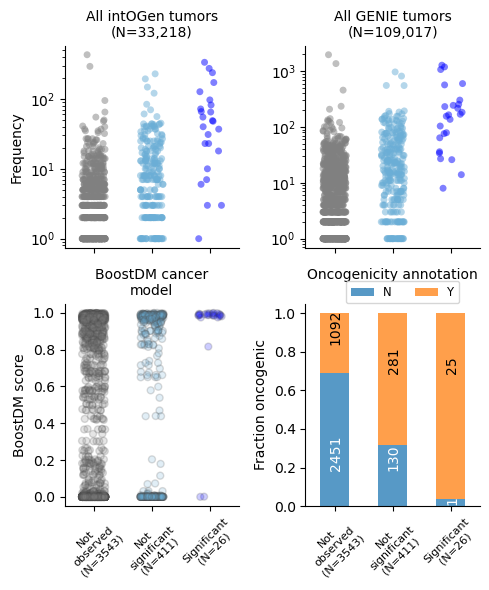

In [20]:
TP53_whole_figure = os.path.join(output_dir,'ExtendedFig10b_TP53_multipanel_saturation.png')

fig, axs = plt.subplots(2, 2, figsize=(5,6), sharex=True)

#Frequency intogen cancer
sns.stripplot(data=table,
              x='group_normal',
              y='count_intogen_cancer',
              jitter=0.2,
              hue='group_normal',
              alpha=0.5,
              edgecolor='none',
              hue_order= ['significant', 'not_significant', 'not_observed'],
              palette=custom_palette,  # Apply the custom palette
              linewidth=1,
              ax=axs[0,0])
axs[0,0].get_legend().remove()
axs[0,0].set_yscale('log')
axs[0,0].set_ylabel('Frequency')
axs[0,0].set_xlabel('')
axs[0,0].set_title('All intOGen tumors\n(N=33,218)', fontsize = 10)
axs[0,0].spines[['top','right']].set_visible(False)

#Frequency GENIE cancer
sns.stripplot(data=table,
              x='group_normal',
              y='count_genie',
              jitter=0.2,
              hue='group_normal',
              alpha=0.5,
              edgecolor='none',
              hue_order= ['significant', 'not_significant', 'not_observed'],
              palette=custom_palette,  # Apply the custom palette
              linewidth=1,
              ax=axs[0,1])
axs[0,1].get_legend().remove()
axs[0,1].set_yscale('log')
axs[0,1].set_ylabel('')
axs[0,1].set_xlabel('')
axs[0,1].set_title('All GENIE tumors\n(N=109,017)', fontsize = 10)
axs[0,1].spines[['top','right']].set_visible(False)


#BoostDM cancer scores
sns.stripplot(data=table,
              x='group_normal',
              y='boostdm_score_cancer',
              jitter=0.2,
              hue='group_normal',
              alpha=0.2,
              size=5,              
              edgecolor='gray',
              hue_order= ['significant', 'not_significant', 'not_observed'],
              palette=custom_palette,  # Apply the custom palette
              linewidth=1,
              ax=axs[1,0])

axs[1,0].get_legend().remove()
axs[1,0].set_ylabel('BoostDM score')
axs[1,0].set_xlabel('')
axs[1,0].set_xticks([0,1,2],
                    ['Not\nobserved\n(N=' + str(size_groups[size_groups['group_normal'] == 'not_observed']['size'].values[0]) + ')',
                    'Not\nsignificant\n(N=' + str(size_groups[size_groups['group_normal'] == 'not_significant']['size'].values[0]) + ')',
                    'Significant\n(N=' + str(size_groups[size_groups['group_normal'] == 'significant']['size'].values[0]) + ')'],
                    rotation=45,
                    fontsize = 8
                   )
axs[1,0].set_title('BoostDM cancer\nmodel', fontsize = 10)
axs[1,0].spines[['top','right']].set_visible(False)

#Oncogenic counts
oncogenic_data.plot(kind='bar', 
                    stacked=True, 
                    alpha=0.75,
                    ax=axs[1,1])
axs[1,1].legend(ncol=2,bbox_to_anchor=(0.2,1.14),
               loc='upper left', fontsize='small'
               # , frameon = False
               )
axs[1,1].set_ylabel('Fraction oncogenic')
axs[1,1].set_xlabel('')
axs[1,1].set_xticks([0,1,2],
                    ['Not\nobserved\n(N=' + str(size_groups[size_groups['group_normal'] == 'not_observed']['size'].values[0]) + ')',
                    'Not\nsignificant\n(N=' + str(size_groups[size_groups['group_normal'] == 'not_significant']['size'].values[0]) + ')',
                    'Significant\n(N=' + str(size_groups[size_groups['group_normal'] == 'significant']['size'].values[0]) + ')'],
                    rotation=45,
                    fontsize = 8
                   )
axs[1,1].set_title('Oncogenicity annotation', fontsize = 10, pad = 18)
axs[1,1].spines[['top','right']].set_visible(False)

axs[1,1].text(-0.1, 0.2, str(oncogenic_values[0.0][0]), fontdict=None, color='white', rotation=90)
axs[1,1].text(-0.1, 0.85, str(oncogenic_values[1.0][0]), fontdict=None, color='black', rotation=90)
axs[1,1].text(0.9, 0.2, str(oncogenic_values[0.0][1]), fontdict=None, color='white', rotation=90)
axs[1,1].text(0.9, 0.7, str(oncogenic_values[1.0][1]), fontdict=None, color='black', rotation=90)
axs[1,1].text(1.9, 0.02, str(oncogenic_values[0.0][2]), fontdict=None, color='white', rotation=90)
axs[1,1].text(1.9, 0.7, str(oncogenic_values[1.0][2]), fontdict=None, color='black', rotation=90)

plt.tight_layout()
plt.savefig(TP53_whole_figure)

# TERT promoter mutations

In [21]:
table_file = os.path.join(tert_data_dir,'TERT_merged_data.tsv')
table = pd.read_csv(table_file,sep='\t')
print(table.shape)
table = table[table["in_consensus"] == 1.0].reset_index(drop = True)
print(table.shape)

(1044, 20)
(987, 20)


In [22]:
table

,chr,pos,ref,alt,site_selection,p_value,count_normal,in_consensus,count_WGS_tumor,freq_WGS_tumor,Consequence,genie_mut_patients,genie_mut_freq,genie_mut_bladder,genie_mut_bladder_freq,VARTYPE,value,p,system,in_saturation
0,chr5,1294942,C,A,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,chr5,1294942,C,G,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,chr5,1294942,C,T,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,chr5,1294943,C,A,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,chr5,1294943,C,G,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,chr5,1295288,C,G,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
983,chr5,1295288,C,T,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
984,chr5,1295289,C,A,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
985,chr5,1295289,C,G,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [23]:
def group_TERT(r):
    if r['count_normal'] == 0:
        return 'not_observed'
    elif r['p_value'] < 1e-5:
        return 'significant'
    elif r['p_value'] >= 1e-5:
        return 'not_significant'

In [24]:
table['group'] = table.apply(group_TERT,axis=1)

In [25]:
size_groups = pd.DataFrame({'size':table.groupby(by='group')['chr'].count()}).reset_index()
size_groups

,group,size
0,not_observed,952
1,not_significant,30
2,significant,5


In [26]:
table_wgs = table[(table["count_WGS_tumor"] > 0)].copy()
table_wgs['group'] = table_wgs.apply(group_TERT,axis=1)
size_groups_wgs = pd.DataFrame({'size':table_wgs.groupby(by='group')['chr'].count()}).reset_index()
size_groups_wgs

,group,size
0,not_observed,45
1,not_significant,4
2,significant,5


In [27]:
table_genie_all = table[(table["genie_mut_patients"] > 0)].copy()
table_genie_all['group'] = table_genie_all.apply(group_TERT,axis=1)
size_groups_genie_all = pd.DataFrame({'size':table_genie_all.groupby(by='group')['chr'].count()}).reset_index()
size_groups_genie_all

,group,size
0,not_observed,195
1,not_significant,13
2,significant,5


In [28]:
table_genie_bladder = table[(table["genie_mut_bladder"] > 0)].copy()
table_genie_bladder['group'] = table_genie_bladder.apply(group_TERT,axis=1)
size_groups_genie_bladder = pd.DataFrame({'size':table_genie_bladder.groupby(by='group')['chr'].count()}).reset_index()
size_groups_genie_bladder

,group,size
0,not_observed,31
1,not_significant,3
2,significant,5


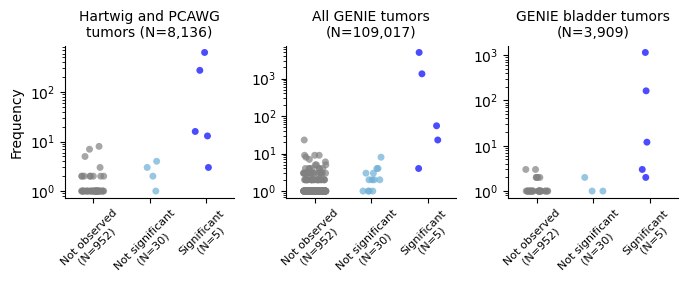

In [29]:
TERT_multipanel_saturation_fig = os.path.join(output_dir,'ExtendedFig10d_TERTp_selection_comparisons.png')

fig, axs = plt.subplots(1, 3, figsize=(7,3), sharex=False)

#Frequency cancer
sns.stripplot(data=table,
              x='group',
              y='count_WGS_tumor',
              jitter=0.2,
              hue='group',
              alpha=0.7,
              edgecolor='none',
              hue_order= ['significant', 'not_significant', 'not_observed'],
              palette=custom_palette,  # Apply the custom palette
              linewidth=1,
              ax=axs[0])
axs[0].legend([], [], frameon=False)
axs[0].set_yscale('log')
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('')
axs[0].set_title('Hartwig and PCAWG\ntumors (N=8,136)', fontsize = 10)
axs[0].spines[['top','right']].set_visible(False)
axs[0].set_xticks([0,1,2],
               ['Not observed\n(N=' + str(size_groups[size_groups['group'] == 'not_observed']['size'].values[0]) + ')',
                'Not significant\n(N=' + str(size_groups[size_groups['group'] == 'not_significant']['size'].values[0]) + ')',
                'Significant\n(N=' + str(size_groups[size_groups['group'] == 'significant']['size'].values[0]) + ')'],
                    rotation=45,
                    fontsize = 8)



#Frequency GENIE cancer
sns.stripplot(data=table,
              x='group',
              y='genie_mut_patients',
              jitter=0.2,
              hue='group',
              alpha=0.7,
              edgecolor='none',
              hue_order= ['significant', 'not_significant', 'not_observed'],
              palette=custom_palette,  # Apply the custom palette
              linewidth=1,
              ax=axs[1])
              
axs[1].legend([], [], frameon=False)
axs[1].set_yscale('log')
axs[1].set_ylabel('')
axs[1].set_xlabel('')
axs[1].set_title('All GENIE tumors\n(N=109,017)', fontsize = 10)
axs[1].spines[['top','right']].set_visible(False)
axs[1].set_xticks([0,1,2],
               ['Not observed\n(N=' + str(size_groups[size_groups['group'] == 'not_observed']['size'].values[0]) + ')',
                'Not significant\n(N=' + str(size_groups[size_groups['group'] == 'not_significant']['size'].values[0]) + ')',
                'Significant\n(N=' + str(size_groups[size_groups['group'] == 'significant']['size'].values[0]) + ')'],
                    rotation=45,
                    fontsize = 8)


#Frequency GENIE bladder
sns.stripplot(data=table,
              x='group',
              y='genie_mut_bladder',
              jitter=0.2,
              hue='group',
              edgecolor='none',
              hue_order= ['significant', 'not_significant', 'not_observed'],
              palette=custom_palette,  # Apply the custom palette
              linewidth=1,
              alpha=0.7,
              ax=axs[2])
axs[2].legend([], [], frameon=False)
axs[2].set_yscale('log')
axs[2].set_ylabel('')
axs[2].set_xlabel('')
axs[2].set_xticks([0,1,2],
               ['Not observed\n(N=' + str(size_groups[size_groups['group'] == 'not_observed']['size'].values[0]) + ')',
                'Not significant\n(N=' + str(size_groups[size_groups['group'] == 'not_significant']['size'].values[0]) + ')',
                'Significant\n(N=' + str(size_groups[size_groups['group'] == 'significant']['size'].values[0]) + ')'],
                    rotation=45,
                    fontsize = 8)
axs[2].set_title('GENIE bladder tumors\n(N=3,909)', fontsize = 10)
axs[2].spines[['top','right']].set_visible(False)

plt.tight_layout()
plt.savefig(TERT_multipanel_saturation_fig)

/tmp/ipykernel_1121330/4087413309.py:8: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(
/tmp/ipykernel_1121330/4087413309.py:8: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(


/tmp/ipykernel_1121330/4087413309.py:8: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(


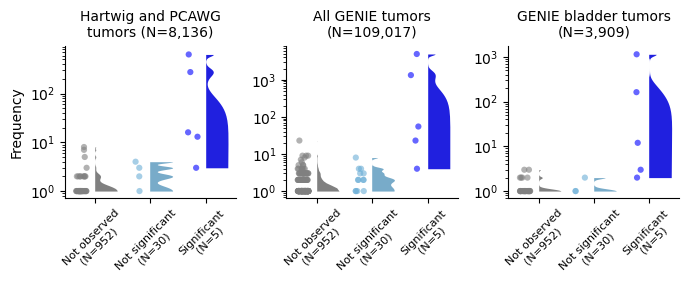

In [ ]:
TERT_multipanel_saturation_fig = os.path.join(output_dir, 'ExtendedFig10d_TERTp_selection_comparisons.png')

# Setup
fig, axs = plt.subplots(1, 3, figsize=(7, 3), sharex=False)

# Reusable plotting function adapted for grouped data
def plot_half_violin_group(ax, data, x_col, y_col, group_order, palette, title, ylabel=None):
    sns.violinplot(
        data=data[(data[y_col] >= 1)],
        ax=ax,
        x=x_col,
        y=y_col,
        hue=x_col,
        hue_order=group_order,
        order=group_order,
        palette=palette,
        inner=None,
        linewidth=0,
        bw=0.2,
        cut=0,
        density_norm='width',
        zorder = 1
    )

    ymin, ymax = ax.get_ylim()

    # Cover left half
    for i, group in enumerate(group_order):
        ax.add_patch(plt.Rectangle((i - 0.41, 0), 0.39, ymax - ymin, color='white', zorder=2))

    group_order = ['not_observed', 'not_significant', 'significant']
    x_offset = -0.25  # fixed offset if you want all dots shifted
    jitter_width = 0.1  # match seaborn's jitter
    dot_size = 20

    for i, group in enumerate(group_order):
        group_data = data[data['group'] == group]
        y_vals = group_data[y_col]
        # x_vals = [i + x_offset] * len(y_vals)# + np.random.uniform(-jitter_width, jitter_width, size=len(y_vals))
        x_vals = i + x_offset + np.random.uniform(-jitter_width, jitter_width, size=len(y_vals))
        ax.scatter(x_vals,
                    y_vals,
                color=palette[group],
                alpha=0.6,
                s=dot_size,
                edgecolor='none',
                linewidth=0,
                label=group, zorder = 3)
        ax.set_yscale("log")


    # # Strip plot overlay
    # sns.stripplot(
    #     data=data,
    #     x=x_col,
    #     y=y_col,
    #     hue=x_col,
    #     order=group_order,
    #     hue_order=group_order,
    #     dodge=False,
    #     jitter=0.25,
    #     alpha=0.6,
    #     linewidth=0,
    #     edgecolor='none',
    #     palette=palette,
    #     size=3,
    #     ax=ax
    # )

    ax.set_yscale("log")
    if ylabel:
        ax.set_ylabel(ylabel)
    else:
        ax.set_ylabel('')
    ax.set_xlabel('')
    # ax.set_ylim(0.8)
    ax.set_title(title, fontsize=10)
    ax.spines[['top', 'right']].set_visible(False)
    ax.legend([], [], frameon=False)

    # Update x-axis tick labels with group sizes
    xtick_labels = [
        f"Not observed\n(N={size_groups[size_groups['group']=='not_observed']['size'].values[0]})",
        f"Not significant\n(N={size_groups[size_groups['group']=='not_significant']['size'].values[0]})",
        f"Significant\n(N={size_groups[size_groups['group']=='significant']['size'].values[0]})"
    ]
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(xtick_labels, rotation=45, fontsize=8)

# Plot each panel
group_order = ['not_observed', 'not_significant', 'significant']
plot_half_violin_group(axs[0], table, 'group', 'count_WGS_tumor', group_order, custom_palette, 'Hartwig and PCAWG\ntumors (N=8,136)', ylabel='Frequency')
plot_half_violin_group(axs[1], table, 'group', 'genie_mut_patients', group_order, custom_palette, 'All GENIE tumors\n(N=109,017)')
plot_half_violin_group(axs[2], table, 'group', 'genie_mut_bladder', group_order, custom_palette, 'GENIE bladder tumors\n(N=3,909)')

# Finalize
plt.tight_layout()
plt.savefig(TERT_multipanel_saturation_fig, dpi=300)
plt.show()


In [28]:
# TERT_multipanel_saturation_fig = os.path.join(output_dir,'ExtendedFig10d_TERTp_selection_comparisons.png')

# fig, axs = plt.subplots(1, 3, figsize=(7,3), sharex=False)

# #Frequency cancer
# sns.stripplot(data=table,
#               x='group',
#               y='count_WGS_tumor',
#               jitter=0.2,
#               hue='group',
#               alpha=0.7,
#               edgecolor='none',
#               hue_order= ['significant', 'not_significant', 'not_observed'],
#               palette=custom_palette,  # Apply the custom palette
#               linewidth=1,
#               ax=axs[0])
# axs[0].legend([], [], frameon=False)
# axs[0].set_yscale('log')
# axs[0].set_ylabel('Frequency')
# axs[0].set_xlabel('')
# axs[0].set_title('Hartwig and PCAWG\ntumors (N=8,136)', fontsize = 10)
# axs[0].spines[['top','right']].set_visible(False)
# axs[0].set_xticks([0,1,2],
#                ['Not observed\n(N=' + str(size_groups_wgs[size_groups_wgs['group'] == 'not_observed']['size'].values[0]) + ')',
#                 'Not significant\n(N=' + str(size_groups_wgs[size_groups_wgs['group'] == 'not_significant']['size'].values[0]) + ')',
#                 'Significant\n(N=' + str(size_groups_wgs[size_groups_wgs['group'] == 'significant']['size'].values[0]) + ')'],
#                     rotation=45,
#                     fontsize = 8)



# #Frequency GENIE cancer
# sns.stripplot(data=table,
#               x='group',
#               y='genie_mut_patients',
#               jitter=0.2,
#               hue='group',
#               alpha=0.7,
#               edgecolor='none',
#               hue_order= ['significant', 'not_significant', 'not_observed'],
#               palette=custom_palette,  # Apply the custom palette
#               linewidth=1,
#               ax=axs[1])
              
# axs[1].legend([], [], frameon=False)
# axs[1].set_yscale('log')
# axs[1].set_ylabel('')
# axs[1].set_xlabel('')
# axs[1].set_title('All GENIE tumors\n(N=109,017)', fontsize = 10)
# axs[1].spines[['top','right']].set_visible(False)
# axs[1].set_xticks([0,1,2],
#                ['Not observed\n(N=' + str(size_groups_genie_all[size_groups_genie_all['group'] == 'not_observed']['size'].values[0]) + ')',
#                 'Not significant\n(N=' + str(size_groups_genie_all[size_groups_genie_all['group'] == 'not_significant']['size'].values[0]) + ')',
#                 'Significant\n(N=' + str(size_groups_genie_all[size_groups_genie_all['group'] == 'significant']['size'].values[0]) + ')'],
#                     rotation=45,
#                     fontsize = 8)


# #Frequency GENIE bladder
# sns.stripplot(data=table,
#               x='group',
#               y='genie_mut_bladder',
#               jitter=0.2,
#               hue='group',
#               edgecolor='none',
#               hue_order= ['significant', 'not_significant', 'not_observed'],
#               palette=custom_palette,  # Apply the custom palette
#               linewidth=1,
#               alpha=0.7,
#               ax=axs[2])
# axs[2].legend([], [], frameon=False)
# axs[2].set_yscale('log')
# axs[2].set_ylabel('')
# axs[2].set_xlabel('')
# axs[2].set_xticks([0,1,2],
#                ['Not observed\n(N=' + str(size_groups_genie_bladder[size_groups_genie_bladder['group'] == 'not_observed']['size'].values[0]) + ')',
#                 'Not significant\n(N=' + str(size_groups_genie_bladder[size_groups_genie_bladder['group'] == 'not_significant']['size'].values[0]) + ')',
#                 'Significant\n(N=' + str(size_groups_genie_bladder[size_groups_genie_bladder['group'] == 'significant']['size'].values[0]) + ')'],
#                     rotation=45,
#                     fontsize = 8)
# axs[2].set_title('GENIE bladder tumors\n(N=3,909)', fontsize = 10)
# axs[2].spines[['top','right']].set_visible(False)

# plt.tight_layout()
# plt.savefig(TERT_multipanel_saturation_fig)